# RISE Camp 2018: Introduction to Flor!


Welcome to RISE Camp 2018! Flor is a system for managing workflow development within the machine learning lifecycle. This tool enables data scientists to describe ML workflows as directed acyclic graphs (DAGs) of Actions, Artifacts, or Literals and to experiment with different configurations quickly by running multi-trial experiments. 

The purpose of this notebook is to help you use Flor in order to naviagte through different parts of the data science lifecycle.

As you work through this notebook, you will learn:

* How to define/use experiments, literals, artifacts and actions.
* How to run experiments with different congigurations.
* Compare models with other past versions in order to select the best model.

We will be working with a ratings dataset. 

**Data science is a collaborative activity - we encourage you to work with those around you and ask questions!**

## Imports

In [1]:
#General imports
import pandas as pd
import numpy as np
import nltk
import json
import time
import random
import scipy.sparse
import flor

#Pre-processing imports
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

#Model training and testing imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score, recall_score, precision_recall_fscore_support

/home/eric/anaconda3/envs/rise/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# If the notebook name has not already been set, you are able to set the name in code. 
flor.setNotebookName('tutorial.ipynb')

## Preprocessing Data

Before building our model, we will define a pipeline to pre-process our text data. We have used the following techniques to pre-process the text reviews:
* Removal of Stop Words
* Stemming (reducing inflected words to their stem)
* Lemmatization (group together inflected forms of a words)

We will wrap the following functions with the @flor.func decorator so they are able to be referenced by Flor actions. 

In [3]:
@flor.func
def preprocessing(data_loc, intermediate_X, intermediate_y, **kwargs):
    '''

    Data Preprocessing

    '''
    print("DATA PREPROCESSING")
#     data = pd.read_json(data_loc)
#     X = data['text']
#     y = data['rating'].astype(np.float64)
    
#     en_stop = get_stop_words('en')

#     def filter_sentence(el):
#         tokens = word_tokenize(el)
#         tokens = [word for word in tokens if word.isalpha()]
#         tokens = [word for word in tokens if word not in en_stop]
#         tokens = stem_words(tokens)
#         tokens = lemma_words(tokens)

#         ret_str = " ".join(tokens) 

#         return ret_str 


#     #Credit to https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html
#     #for stem_words and lemma_words
#     def stem_words(words):
#         stemmer = PorterStemmer()
#         stems = []
#         for word in words:
#             stem = stemmer.stem(word)
#             stems.append(stem)
#         return stems

#     def lemma_words(words):
#         lemmatizer = WordNetLemmatizer()
#         lemmas = []
#         for word in words:
#             lemma = lemmatizer.lemmatize(word, pos='v')
#             lemmas.append(lemma)
#         return lemmas

#     start_time = time.time()
#     X = [filter_sentence(el) for el in X]
#     print("--- %s seconds ---" % (time.time() - start_time))

#     y_new = []
#     for el in y:
#         ret = 0
#         if el <= 5:
#             ret = 0
#         else:
#             ret = 1
#         y_new.append(ret)
#     y = y_new

    # Load the cleaned data
    with open('data_clean_X.json') as json_data:
        X = json.load(json_data)
        json_data.close()
    with open('data_clean_y.json') as json_data:
        y = json.load(json_data)
        json_data.close()

    with open(intermediate_X, 'w') as outfile:
       json.dump(X, outfile)
    with open(intermediate_y, 'w') as outfile:
       json.dump(y, outfile)

## Train Test Split

We create a flor function to split our data into training and test sets. 

In [4]:
@flor.func
def traintest_split(intermediate_X, intermediate_y, X_train, X_test, y_train, y_test, **kwargs):
    '''

    Flor function to perform train/test split.

    '''
    with open(intermediate_X) as json_data:
        X = json.load(json_data)
        json_data.close()
    with open(intermediate_y) as json_data:
        y = json.load(json_data)
        json_data.close()
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=92)
#     def train_drop(el):
#         tokens = word_tokenize(el)
#         tokens = [el for el in tokens if random.random() >= 0.75]
#         ret_str = " ".join(tokens) 
#         return ret_str 
#     X_tr = [train_drop(el) for el in X_tr]
    vectorizer = TfidfVectorizer()
    start_time = time.time()
    vectorizer.fit(X_tr)
    X_tr = vectorizer.transform(X_tr)
    X_te = vectorizer.transform(X_te)
    with open(y_train, 'w') as outfile:
        json.dump(y_tr, outfile)
    with open(y_test, 'w') as outfile:
        json.dump(y_te, outfile)

    print("saving sparse matrices")
    scipy.sparse.save_npz(X_train, X_tr)
    scipy.sparse.save_npz(X_test, X_te)

## Model Training and Evaluation

Now, we can create a Flor function to train and evaluate a model to classify reviews into rating buckets. Notice that we pass in `hyperparameters` in addition to the train and test data. These hyperparameters will allow us to tune our model and track results with ease; we will define them later in our experiment setup.

In [5]:
@flor.func
def train_test(X_train, X_test, y_train, y_test, hyperparameters, precision, recall, **kwargs):
    '''

    Flor function to train and evaluate model.

    '''
    print("Loading Data")
    X_train = scipy.sparse.load_npz(X_train)
    X_test = scipy.sparse.load_npz(X_test)
    with open(y_train) as json_data:
        y_train = json.load(json_data)
        json_data.close()
    with open(y_test) as json_data:
        y_test = json.load(json_data)
        json_data.close()
    print("Training Model")
    
    #Either train Random Forest or Multi-layer Perception Classifier
    clf = RandomForestClassifier(n_estimators=hyperparameters).fit(X_train, y_train)
    clf.fit(X_train, y_train)
    
    #clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(2, ), random_state=1).fit(X_train, y_train)
    #clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(2, ), random_state=1).fit(X_train, y_train)    
    #clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(2, ), random_state=1, max_iter = 1000).fit(X_train, y_train)
    #clf = MultinomialNB().fit(X_train, y_train)
    clf = DecisionTreeClassifier(splitter=hyperparameters).fit(X_train, y_train)
    #clf = KNeighborsClassifier().fit(X_train, y_train)

    print("Predicting Model")
    y_pred = clf.predict(X_test)
    
    print("Writing Results") 
    
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    #Write the precision to the output file
    output = open(precision, 'w')
    output.write(str(hyperparameters) + '\n')
    output.write(str(prec))
    output.close()
    
    #Write the recall to the output file
    output = open(recall, 'w')
    output.write(str(hyperparameters) + '\n')
    output.write(str(rec))
    output.close()
    

## Experiment Setup

Finally, we will now define our Flor experiment using the Flor functions we created above.

In [6]:
# Create a context manager for the experiment and is named 'risecamp_demo'
with flor.Experiment("risecamp_demo") as ex:
    ex.groundClient('git') #use "git" from grit and "ground" for ground
    
    # Defines preprocessing action and resulting intermediary artifacts
    data = ex.artifact('data.json', 'data_loc')
    preprocessing = ex.action(preprocessing, [data])
    data_x = ex.artifact('data_clean_X.json', 'intermediate_X', preprocessing)
    data_y = ex.artifact('data_clean_y.json', 'intermediate_y', preprocessing)
    
    #Define split action and resulting output artifacts
    do_split = ex.action(traintest_split, [data_x, data_y])
    X_train = ex.artifact('x_train.npz', 'X_train', do_split)
    X_test = ex.artifact('x_test.npz', 'X_test', do_split)
    y_train = ex.artifact('y_train.json', 'y_train', do_split)
    y_test = ex.artifact('y_test.json', 'y_test', do_split)
    
    #Define the hyperparameters for the models
    random_forest_Nestimators = ex.literalForEach(v=[25, 50, 75], name="hyperparameters", default=50)
    #MLP_hidden_layer_size = ex.literalForEach(v=[(1, ), (2, ), (3, )], name="hyperparameters", default=(2, ))
    #k_neighbors_num = ex.literalForEach(v=[2, 5, 8], name="hyperparameters", default=5)
    
    #Define the model training and evaluation action and final artifacts
    #change to MLP_hidden_layer_size 
    do_test = ex.action(train_test, [X_train, X_test, y_train, y_test, decision_tree_splitter])
    #for naive bayes
#     do_test = ex.action(train_test, [X_train, X_test, y_train, y_test])
    precision = ex.artifact('precision.txt', 'precision', do_test)
    recall = ex.artifact('recall.txt', 'recall', do_test)
    

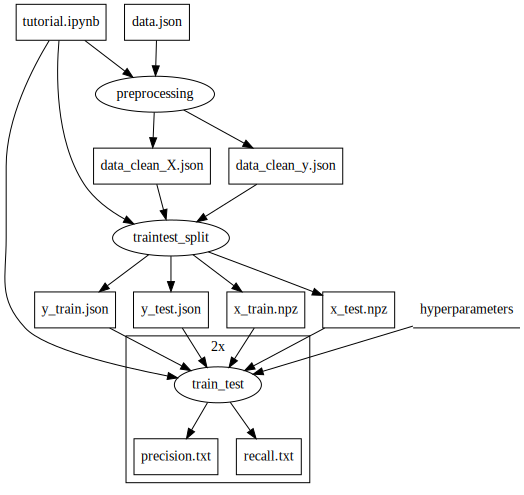

In [7]:
#Create a graph representation of the precision artifact's lineage
precision.plot()

In [8]:
#Run the experiment
precision.pull()

DATA PREPROCESSING
saving sparse matrices
Loading Data
Training Model


KeyError: 'entropy'